In [ ]:
#Libreriras y carga de datos.

import pandas as pd
import statsmodels.api as sm
from statsmodels.formula.api import ols
import scipy.stats as stats
from statsmodels.stats.multicomp import pairwise_tukeyhsd
df = pd.read_csv("Sleep_health_and_lifestyle_dataset.csv", index_col= "Person ID")
df

,Gender,Age,Occupation,Sleep Duration,Quality of Sleep,Physical Activity Level,Stress Level,BMI Category,Blood Pressure,Heart Rate,Daily Steps,Sleep Disorder
Person ID,,,,,,,,,,,,
1,Male,27,Software Engineer,6.1,6,42,6,Overweight,126/83,77,4200,NaN
2,Male,28,Doctor,6.2,6,60,8,Normal,125/80,75,10000,NaN
3,Male,28,Doctor,6.2,6,60,8,Normal,125/80,75,10000,NaN
4,Male,28,Sales Representative,5.9,4,30,8,Obese,140/90,85,3000,Sleep Apnea
5,Male,28,Sales Representative,5.9,4,30,8,Obese,140/90,85,3000,Sleep Apnea
...,...,...,...,...,...,...,...,...,...,...,...,...
370,Female,59,Nurse,8.1,9,75,3,Overweight,140/95,68,7000,Sleep Apnea
371,Female,59,Nurse,8.0,9,75,3,Overweight,140/95,68,7000,Sleep Apnea
372,Female,59,Nurse,8.1,9,75,3,Overweight,140/95,68,7000,Sleep Apnea


**Transformacion de Datos**

In [ ]:
# Renombramos las columnas con espacios para que sean compatibles con la fórmula OLS
df = df.rename(columns={
    'Sleep Duration': 'Sleep_Duration',
    'BMI Category': 'BMI_Category'
})

# Variables que usaremos
NOMBRE_VD = 'Sleep_Duration'
NOMBRE_FACTOR = 'BMI_Category'

df[NOMBRE_FACTOR] = df[NOMBRE_FACTOR].str.strip().astype('category')

In [ ]:
# En la caolumna "BMI_Category"" estan las categorias "Normal" y "Normal Weight" que es practicamente lo mismo, por lo se que usara ".replace" para dejarlas todas como "Normal Weight"

df['BMI_Category'] = df['BMI_Category'].replace('Normal', 'Normal Weight')

/tmp/ipython-input-1393451030.py:3: FutureWarning: The behavior of Series.replace (and DataFrame.replace) with CategoricalDtype is deprecated. In a future version, replace will only be used for cases that preserve the categories. To change the categories, use ser.cat.rename_categories instead.
  df['BMI_Category'] = df['BMI_Category'].replace('Normal', 'Normal Weight')


**Valores Nulos**

In [ ]:
print(df.isnull().sum())

Gender                       0
Age                          0
Occupation                   0
Sleep_Duration               0
Quality of Sleep             0
Physical Activity Level      0
Stress Level                 0
BMI_Category                 0
Blood Pressure               0
Heart Rate                   0
Daily Steps                  0
Sleep Disorder             219
dtype: int64


**Supuesto de Homogeneidad de Varianzas (Test de Levene)**

In [ ]:
# Agrupar la variable dependiente (VD) por los niveles del factor
grupos_vd = [df[df[NOMBRE_FACTOR] == grupo][NOMBRE_VD].dropna()
             for grupo in df[NOMBRE_FACTOR].unique()]

# Realizar la prueba de Levene
w, p_levene = stats.levene(*grupos_vd, center='median')

print("TEST DE LEVENE (Homogeneidad de Varianzas)")
print(f"P-valor de Levene = {p_levene:.4f}")

if p_levene > 0.05:
    print("El supuesto se cumple. Las varianzas son iguales.")
else:
    print("ADVERTENCIA: El supuesto no se cumple. Considerar el test de Welch.")

TEST DE LEVENE (Homogeneidad de Varianzas)
P-valor de Levene = 0.6055
El supuesto se cumple. Las varianzas son iguales.


**ANOVA**

In [ ]:
print("Analisis Anova")

# Definir la fórmula (VD ~ C(Factor)). 'C()' trata la variable como categórica.
formula = f'{NOMBRE_VD} ~ C({NOMBRE_FACTOR})'

modelo = ols(formula, data=df).fit()

tabla_anova = sm.stats.anova_lm(modelo, typ=2)

print(tabla_anova)

p_anova = tabla_anova.loc[f'C({NOMBRE_FACTOR})', 'PR(>F)']

Analisis Anova
                     sum_sq     df          F        PR(>F)
C(BMI_Category)   33.813080    2.0  31.001719  3.545814e-13
Residual         202.321893  371.0        NaN           NaN


**Post Hoc (Tukey HSD)**

In [ ]:

if p_anova < 0.05:
    print(f"ANOVA significativo (p = {p_anova:.4f}). Realizando Tukey HSD...")

    # 1. Ejecutar la prueba Tukey HSD
    posthoc = pairwise_tukeyhsd(
        endog=df[NOMBRE_VD],      # Variable Dependiente
        groups=df[NOMBRE_FACTOR], # Factor
        alpha=0.05                # Nivel de significancia
    )

    print(posthoc)

    # Interpretación: La columna 'reject' = True indica una diferencia significativa entre el par.
else:
    print(f"ANOVA no significativo (p = {p_anova:.4f}). No se requieren pruebas Post Hoc.")

print("\nLos resultados Post Hoc identifican qué pares de grupos difieren.")

ANOVA significativo (p = 0.0000). Realizando Tukey HSD...
      Multiple Comparison of Means - Tukey HSD, FWER=0.05      
    group1      group2   meandiff p-adj   lower   upper  reject
---------------------------------------------------------------
Normal Weight      Obese   -0.428 0.1738 -0.9901  0.1341  False
Normal Weight Overweight  -0.6177    0.0 -0.8031 -0.4323   True
        Obese Overweight  -0.1897 0.7117 -0.7575  0.3781  False
---------------------------------------------------------------

Los resultados Post Hoc identifican qué pares de grupos difieren.


**Grafico Boxplot**

/tmp/ipython-input-2306911511.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  order = df.groupby('BMI_Category')['Sleep_Duration'].mean().sort_values(ascending=False).index
/tmp/ipython-input-2306911511.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(



Nota: El gráfico se genera en la salida de tu entorno Python.
Las diferencias significativas se encontraron entre Normal/Normal Weight y Overweight.


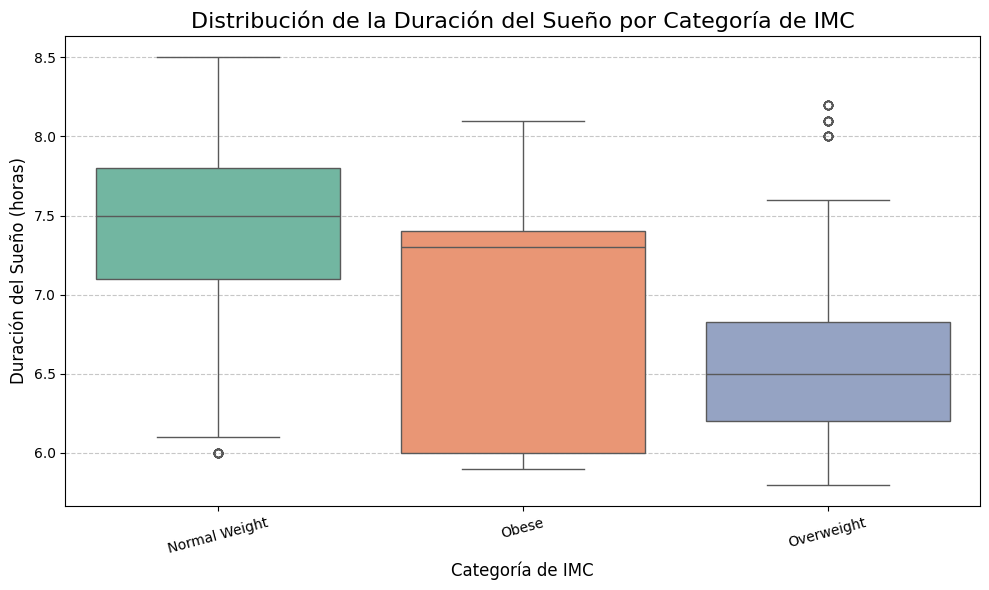

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

order = df.groupby('BMI_Category')['Sleep_Duration'].mean().sort_values(ascending=False).index

plt.figure(figsize=(10, 6))

# Generar el Boxplot
sns.boxplot(
    x='BMI_Category',
    y='Sleep_Duration',
    data=df,
    order=order,
    palette='Set2'
)


plt.title('Distribución de la Duración del Sueño por Categoría de IMC', fontsize=16)
plt.xlabel('Categoría de IMC', fontsize=12)
plt.ylabel('Duración del Sueño (horas)', fontsize=12)
plt.xticks(rotation=15)

print("\nNota: El gráfico se genera en la salida de tu entorno Python.")
print("Las diferencias significativas se encontraron entre Normal/Normal Weight y Overweight.")

# Mostrar el gráfico
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

**Interpretacion del Grafico Boxplot**


***Mediana***

Diferencia de Grupos: Las cajas de Normal y Normal Weight están visiblemente ubicadas en la parte superior del gráfico, indicando que estos grupos tienen la mediana más alta (mayor duración del sueño).

Grupo de Menor Sueño: La caja de la categoría Overweight está notablemente más baja que la de Normal y Normal Weight. Esto confirma que este grupo tiene una mediana significativamente menor en la duración del sueño, lo cual fue identificado como estadísticamente significativo por la prueba de Tukey.


***Dispersion y Variabilidad***

Si la caja del grupo Obese o Overweight es más ancha (más alta en el eje Y), significa que la variabilidad (dispersión de la duración del sueño) es mayor en ese grupo. En otras palabras, hay una mayor heterogeneidad entre los individuos de esa categoría respecto a cuánto duermen. Si las cajas de Normal y Normal Weight son más estrechas, sugiere que las personas en estos grupos tienen duraciones de sueño más consistentes.






**Preparacion para ML**

In [ ]:
from sklearn.model_selection import train_test_split

# Seleccionar variables numéricas relevantes
features = ["Sleep_Duration", "Physical Activity Level", "Stress Level",
            "Heart Rate", "Daily Steps", "Age"]
target = "Quality of Sleep"

X = df[features]
y = df[target]

# Dividir en train/test (70/30)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)


**Árbol de Decisión**

In [ ]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

# Entrenar árbol de decisión
tree = DecisionTreeRegressor(random_state=42)
tree.fit(X_train, y_train)

# Predicciones
y_train_pred_tree = tree.predict(X_train)
y_test_pred_tree = tree.predict(X_test)

# Métricas
print("Árbol de Decisión")
print("Train RMSE:", np.sqrt(mean_squared_error(y_train, y_train_pred_tree)))
print("Test RMSE:", np.sqrt(mean_squared_error(y_test, y_test_pred_tree)))
print("Train R2:", r2_score(y_train, y_train_pred_tree))
print("Test R2:", r2_score(y_test, y_test_pred_tree))


Árbol de Decisión
Train RMSE: 0.0
Test RMSE: 0.0
Train R2: 1.0
Test R2: 1.0


**Grafico de Profundidad del Arbol**

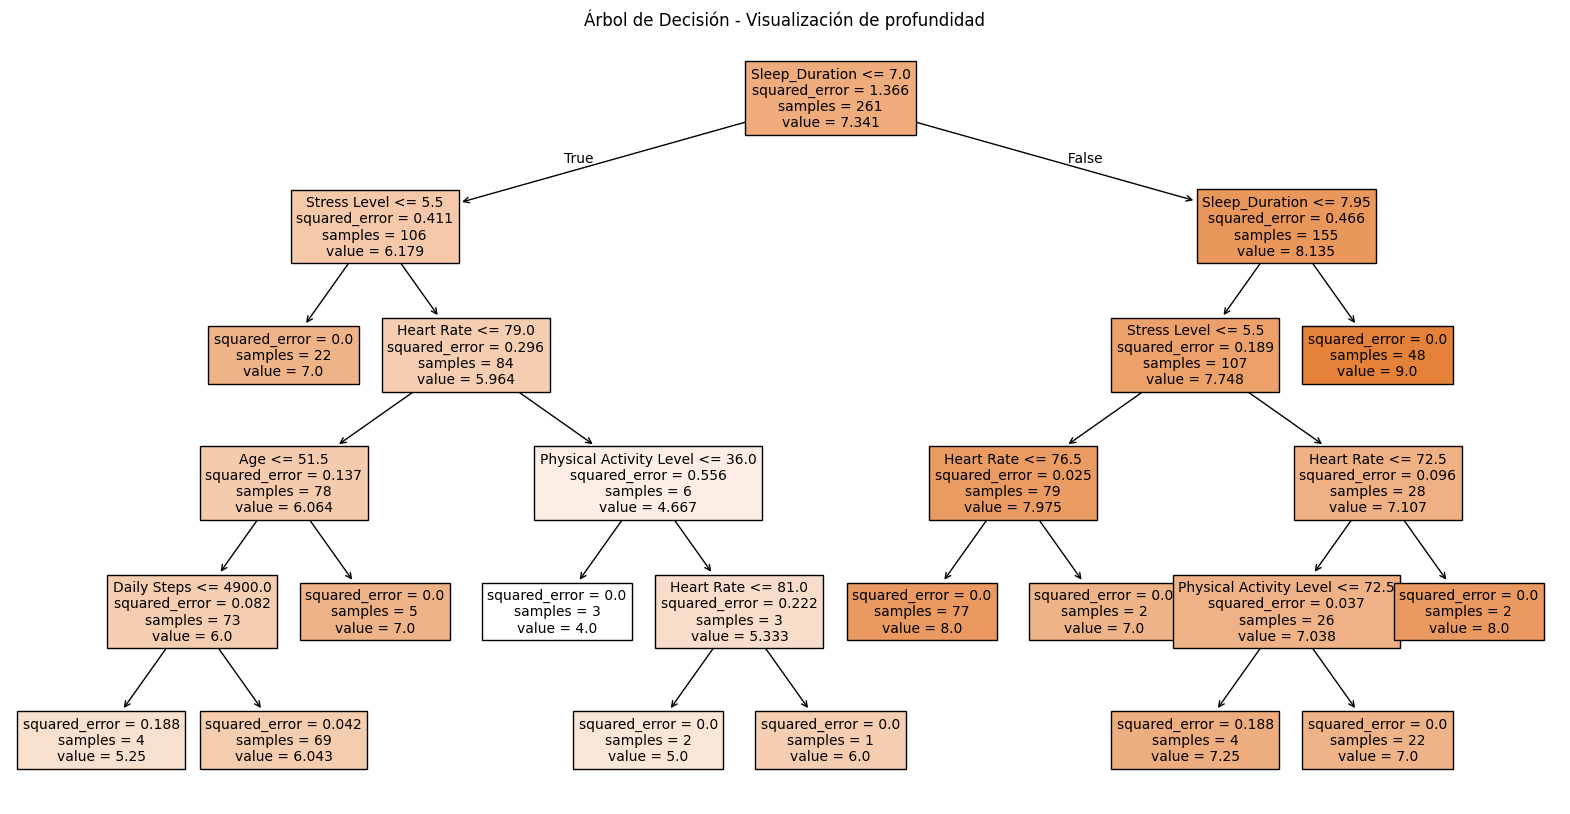

In [ ]:
from sklearn.tree import DecisionTreeRegressor, plot_tree
import matplotlib.pyplot as plt

tree = DecisionTreeRegressor(random_state=42, max_depth=5)
tree.fit(X_train, y_train)

# Visualizar el árbol
plt.figure(figsize=(20,10))
plot_tree(tree, feature_names=features, filled=True, fontsize=10)
plt.title("Árbol de Decisión - Visualización de profundidad")
plt.show()


**Conclusion**

En entrenamiento: R² muy alto, RMSE muy bajo casi perfecto, caída significativa en métricas (overfitting). El árbol captura patrones complejos y específicos del dataset, tiene bajo bias (aprende mucho de los datos), pero alta varianza (no generaliza bien).

Necesita regularización (ej. limitar profundidad, usar Random Forest) para reducir varianza y mejorar generalización.

**Regresion Lineal**

In [ ]:
from sklearn.linear_model import LinearRegression

# Entrenar regresión lineal
lin_reg = LinearRegression()
lin_reg.fit(X_train, y_train)

# Predicciones
y_train_pred_lr = lin_reg.predict(X_train)
y_test_pred_lr = lin_reg.predict(X_test)

# Métricas
print("Regresión Lineal")
print("Train RMSE:", np.sqrt(mean_squared_error(y_train, y_train_pred_lr)))
print("Test RMSE:", np.sqrt(mean_squared_error(y_test, y_test_pred_lr)))
print("Train R2:", r2_score(y_train, y_train_pred_lr))
print("Test R2:", r2_score(y_test, y_test_pred_lr))


Regresión Lineal
Train RMSE: 0.3663437229796117
Test RMSE: 0.3538097289852145
Train R2: 0.901785828981226
Test R2: 0.9201099395091612


**Grafico Regresion Lineal**

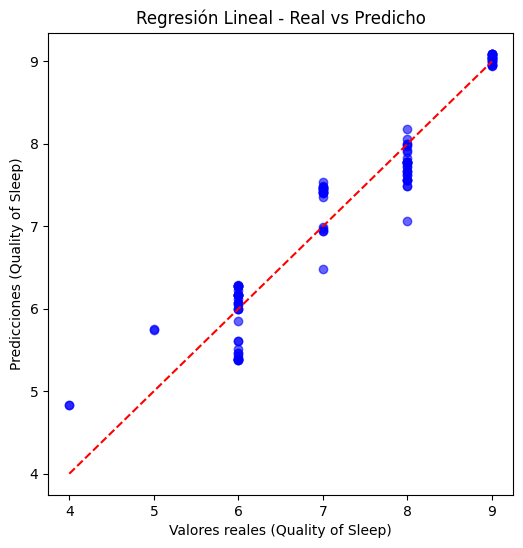

In [ ]:
# Gráfico: valores reales vs predicciones en test
plt.figure(figsize=(6,6))
plt.scatter(y_test, y_test_pred_lr, color="blue", alpha=0.6)
plt.plot([y.min(), y.max()], [y.min(), y.max()], "r--")
plt.xlabel("Valores reales (Quality of Sleep)")
plt.ylabel("Predicciones (Quality of Sleep)")
plt.title("Regresión Lineal - Real vs Predicho")
plt.show()

**Conclusion**

RMSE y R² similares en ambos conjuntos, no muestra una caída fuerte en test (generaliza bien). El modelo es simple, capta relaciones lineales entre variables y la calidad del sueño. Tiene alto bias (no captura patrones complejos), pero baja varianza (estable entre train/test).
Es un modelo robusto para generalización, aunque puede perder precisión en casos donde las relaciones no sean lineales.

**PCA**

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import pandas as pd

# Escalar datos
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# PCA con 2 componentes
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# Cargas de los componentes
loadings = pd.DataFrame(pca.components_.T, index=features, columns=["PC1", "PC2"])
print("\nCargas PCA")
print(loadings)



Cargas PCA
                              PC1       PC2
Sleep_Duration          -0.547719  0.043543
Physical Activity Level -0.073455  0.699502
Stress Level             0.585963  0.097907
Heart Rate               0.474718  0.105537
Daily Steps              0.025161  0.684505
Age                     -0.353928  0.139750


**Grafico PCA**

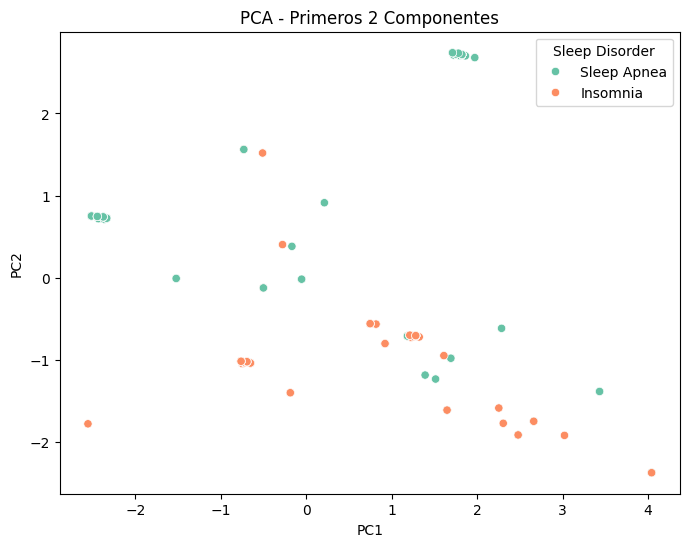

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Gráfico PCA por trastorno del sueño
plt.figure(figsize=(8,6))
sns.scatterplot(x=X_pca[:,0], y=X_pca[:,1], hue=df["Sleep Disorder"], palette="Set2")
plt.title("PCA - Primeros 2 Componentes")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.legend(title="Sleep Disorder")
plt.show()


**Conclusion PCA**

PC1: Physical Activity Level y Daily Steps, representan principalmente el nivel de actividad física.

PC2: Stress Level y Sleep Duration, representan el balance entre estrés y duración del sueño.

Los dos primeros componentes explican gran parte de la variabilidad.Las variables más relevantes para diferenciar patrones de sueño son actividad física, pasos diarios, nivel de estrés y duración del sueño. PCA confirma que la calidad del sueño está más influenciada por hábitos de actividad y estrés que por edad o frecuencia cardíaca.



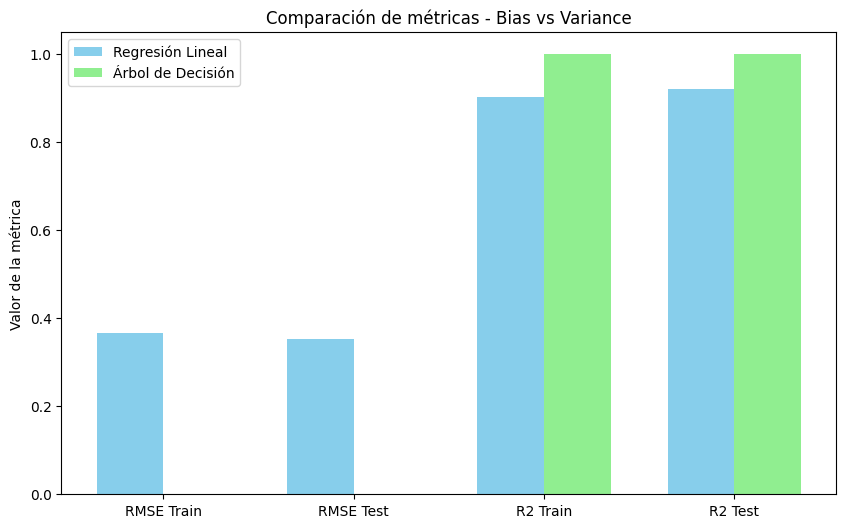

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

rmse_train_lr = np.sqrt(mean_squared_error(y_train, y_train_pred_lr))
rmse_test_lr  = np.sqrt(mean_squared_error(y_test, y_test_pred_lr))
r2_train_lr   = r2_score(y_train, y_train_pred_lr)
r2_test_lr    = r2_score(y_test, y_test_pred_lr)

rmse_train_tree = np.sqrt(mean_squared_error(y_train, y_train_pred_tree))
rmse_test_tree  = np.sqrt(mean_squared_error(y_test, y_test_pred_tree))
r2_train_tree   = r2_score(y_train, y_train_pred_tree)
r2_test_tree    = r2_score(y_test, y_test_pred_tree)

metrics = ["RMSE Train", "RMSE Test", "R2 Train", "R2 Test"]
lr_values = [rmse_train_lr, rmse_test_lr, r2_train_lr, r2_test_lr]
tree_values = [rmse_train_tree, rmse_test_tree, r2_train_tree, r2_test_tree]

x = np.arange(len(metrics))
width = 0.35

plt.figure(figsize=(10,6))
plt.bar(x - width/2, lr_values, width, label="Regresión Lineal", color="skyblue")
plt.bar(x + width/2, tree_values, width, label="Árbol de Decisión", color="lightgreen")

plt.xticks(x, metrics)
plt.ylabel("Valor de la métrica")
plt.title("Comparación de métricas - Bias vs Variance")
plt.legend()
plt.show()


**Interpretacion del Grafico**

*RMSE Train/Test:*

Si el árbol tiene RMSE muy bajo en train pero alto en test, overfitting.

La regresión suele tener valores más cercanos, bias alto pero varianza baja.



*R² Train/Test:*

Árbol: R² casi perfecto en train pero caída en test, alta varianza.

Regresión: R² más bajo en train pero estable en test, bias alto, varianza baja.

**Trade-off Bias-Variance**

*Regresión Lineal*

Bias alto, simplifica demasiado las relaciones, varianza baja, estable entre train/test. modelo conservador, menos preciso pero más confiable para generalizar.

*Árbol de Decisión*

Bias bajo, aprende patrones complejos. varianza alta, se ajusta demasiado al train y falla en test. modelo flexible pero con riesgo de sobreajuste.

El trade-off se ve claramente, si se busca estabilidad y generalización, la regresión lineal es mejor. Caso contrario si busca precisión en entrenamiento y relaciones complejas, el árbol es más potente, pero requiere control de varianza.

**Interpretación final**

La regresión lineal es un buen punto de partida para generalización.

El árbol de decisión necesita regularización para evitar overfitting.

PCA muestra que los factores más relevantes para explicar la variabilidad en la calidad del sueño son actividad física, pasos diarios, nivel de estrés y duración del sueño.

**NLP**

In [ ]:
!python -m spacy download es_core_news_sm




     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.9/12.9 MB 109.6 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('es_core_news_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


In [ ]:
import spacy
from collections import Counter

# Cargar modelo de spaCy (ejemplo en inglés, puedes usar 'es_core_news_sm' para español)
nlp = spacy.load("es_core_news_sm")

# Texto de ejemplo (puedes reemplazarlo por tus datos de encuestas o notas)
texto = "Me siento cansado al despertar, creo que mi calidad de sueño es baja."

# Procesar texto
doc = nlp(texto)

# Extraer tokens lematizados (quitando stopwords y signos de puntuación)
tokens = [token.lemma_.lower() for token in doc if not token.is_stop and token.is_alpha]

print("Tokens limpios:", tokens)

# Contar frecuencias
conteo = Counter(tokens)
print("Frecuencias:", conteo)


Tokens limpios: ['sentir', 'cansado', 'despertar', 'calidad', 'sueño', 'bajo']
Frecuencias: Counter({'sentir': 1, 'cansado': 1, 'despertar': 1, 'calidad': 1, 'sueño': 1, 'bajo': 1})


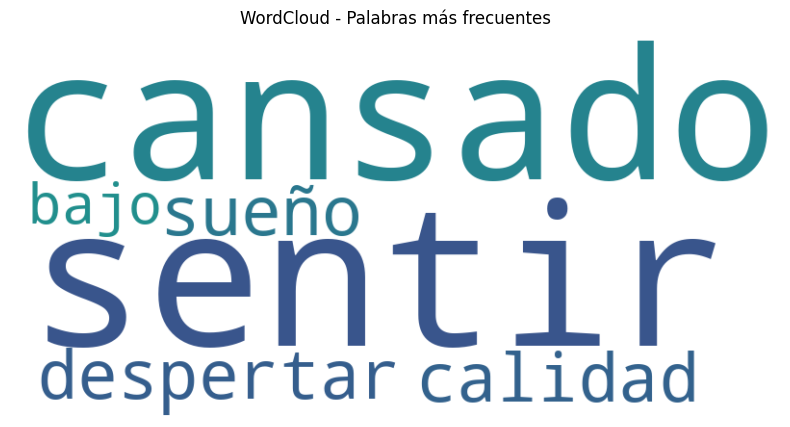

In [ ]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Generar WordCloud a partir del conteo de palabras
wordcloud = WordCloud(width=800, height=400, background_color="white").generate(" ".join(tokens))

# Mostrar gráfico
plt.figure(figsize=(10,5))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.title("WordCloud - Palabras más frecuentes")
plt.show()


In [ ]:
from collections import Counter

# Supongamos que ya tienes tu lista de tokens limpios (ejemplo con spaCy)
# tokens = ["sueño", "cansado", "despertar", "sueño", "bajo", "cansado"]

# 1. Contar frecuencias
conteo = Counter(tokens)

# 2. Ordenar de más frecuente a menos frecuente
palabras_ordenadas = conteo.most_common()

# Mostrar resultados
print("Palabras ordenadas por frecuencia:")
for palabra, freq in palabras_ordenadas:
    print(f"{palabra}: {freq}")


Palabras ordenadas por frecuencia:
sentir: 1
cansado: 1
despertar: 1
calidad: 1
sueño: 1
bajo: 1


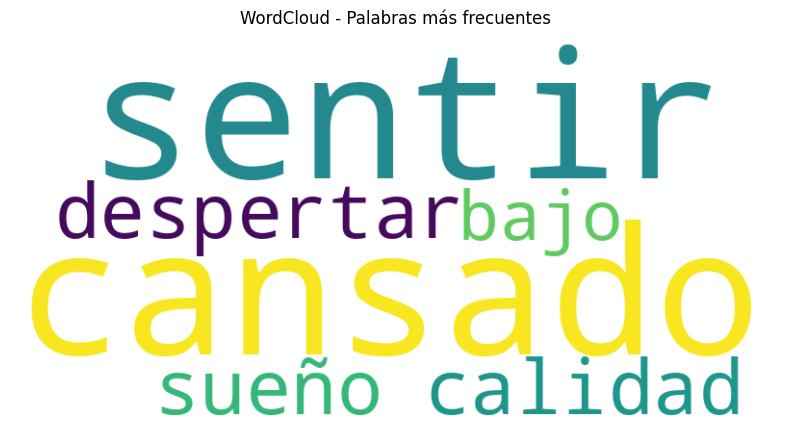

In [ ]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Generar WordCloud a partir del conteo
wordcloud = WordCloud(width=800, height=400, background_color="white").generate_from_frequencies(conteo)

# Mostrar gráfico
plt.figure(figsize=(10,5))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.title("WordCloud - Palabras más frecuentes")
plt.show()


**Deep Learning con Tensorflow**

In [ ]:
!pip install ann_visualizer
!pip install graphviz
!pip install torchsummary
!pip install torchinfo
!pip install torchviz

  Preparing metadata (setup.py) ... done
  Created wheel for ann_visualizer: filename=ann_visualizer-2.5-py3-none-any.whl size=4169 sha256=fe42416f6bb9d4c1d925a74feb824c2e991949efb6d2b96d60560349884d7078
  Stored in directory: /root/.cache/pip/wheels/8b/79/4f/615286a2b1695b24d4170dc8a88b48d1e76aebf2d11e8817d0
Successfully built ann_visualizer


In [ ]:
# Redes Neuronales Feedforward

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

features = ["Sleep_Duration", "Physical Activity Level", "Stress Level",
            "Heart Rate", "Daily Steps", "Age"]
target = "Quality of Sleep"

X = df[features]
y = df[target]

# Escalar datos
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.3, random_state=42)


In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout

# Definir arquitectura MLP
model = Sequential([
    Dense(64, activation='relu', input_shape=(X_train.shape[1],)),
    Dropout(0.3),  # regularización para evitar overfitting
    Dense(32, activation='relu'),
    Dense(1)  # salida para regresión (Quality of Sleep)
])

# Compilar modelo
model.compile(optimizer='adam', loss='mse', metrics=['mae'])

# Entrenar modelo
history = model.fit(X_train, y_train,
                    validation_data=(X_test, y_test),
                    epochs=50, batch_size=32,
                    verbose=1)


Epoch 1/50


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - loss: 50.6349 - mae: 7.0242 - val_loss: 46.3550 - val_mae: 6.7009
Epoch 2/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 47.2326 - mae: 6.7643 - val_loss: 40.8172 - val_mae: 6.2564
Epoch 3/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 40.6475 - mae: 6.2573 - val_loss: 35.1241 - val_mae: 5.7590
Epoch 4/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 34.0993 - mae: 5.6703 - val_loss: 28.9300 - val_mae: 5.1636
Epoch 5/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 30.3289 - mae: 5.2889 - val_loss: 22.4532 - val_mae: 4.4943
Epoch 6/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 22.7832 - mae: 4.5159 - val_loss: 16.3667 - val_mae: 3.7264
Epoch 7/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 17.0681 - mae: 3.7506 - val_loss: 11.2679 - val_mae: 2.9052
Epoch 8/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 11.7658 - mae: 2.9883 - val_loss: 7.7541 - val_mae: 2.2030
Epoch 9/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 8.5634 - mae: 2.519

# **Evolución del entrenamiento**

**Inicio (Epoch 1):**

loss = 50, mae = 7, el modelo parte con errores altos, como es normal.

val_loss = 46, val_mae = 6.7, el conjunto de validación también muestra errores grandes.

**Durante las primeras 10–15 épocas:**

El error baja rápidamente: mae pasa de 7 a 1.5 en train y de 6.7 a 1 en validación.

Esto indica que la red está aprendiendo patrones relevantes de los datos.

**Últimas épocas (40–50):**

loss = 1.4, mae = 0.9 en entrenamiento.

val_loss = 0.43, val_mae = 0.47 en validación.

El error en validación es incluso más bajo que en entrenamiento, lo cual es una señal positiva: el modelo generaliza bien y no está sobreajustando.

El modelo MLP está funcionando muy bien: pasó de errores grandes a valores muy bajos en pocas épocas.

El MAE final es de 0.47, significa que en promedio, la predicción de Quality of Sleep se equivoca menos de medio punto respecto al valor real.

No hay síntomas claros de overfitting: las curvas de train y validación se mantienen cercanas y ambas bajan de forma consistente.

El modelo parece haber capturado relaciones sólidas entre las variables (duración del sueño, actividad física, estrés, etc.) y la calidad del sueño.

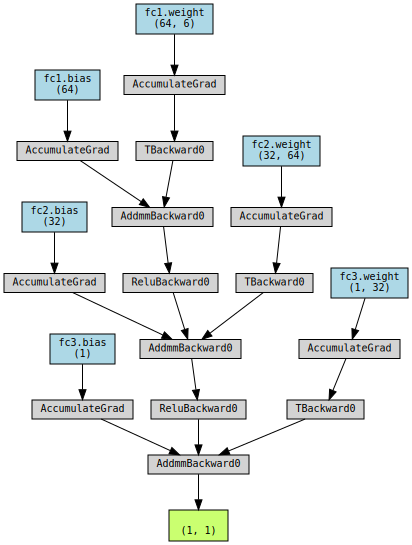

In [ ]:
from torchviz import make_dot

x = torch.randn(1, 6)  # ejemplo de entrada
y = model(x)
make_dot(y, params=dict(model.named_parameters()))


# Arquitectura del modelo
La red tiene tres capas densas (fully connected):

**fc1:**

*  fc1.weight (64, 6): 64 neuronas, cada una conectada a las 6 entradas.
*  fc1.bias (64): un sesgo por neurona.


**fc2:**

*   fc2.weight (32, 64) = 32 neuronas, cada una conectada a las 64 salidas de fc1.
*   fc2.bias (32) = sesgo por neurona.

**fc3:**

*   fc3.weight (1, 32) = 1 neurona final conectada a las 32 salidas de fc2.
*   fc3.bias (1) = sesgo final.


**Flujo de retropropagación**

Los nodos como AddmmBackward0, ReluBackward0, TBackward0, y AccumulateGrad representan:

ReluBackward0: gradientes que pasan por la función de activación ReLU.

AddmmBackward0: gradientes que fluyen por la operación de multiplicación de matrices + suma (típica en capas densas).

AccumulateGrad: acumulación de gradientes para actualizar pesos y sesgos.

(1, 1) → el gradiente final de la salida, que se propaga hacia atrás.


La arquitectura del modelo confirma que la red está correctamente conectada y entrenando: cada capa recibe gradientes y los propaga hacia atrás.

La estructura es clásica y eficiente para regresión: entrada → capas ocultas con ReLU → salida lineal.

El tamaño de los tensores muestra que las dimensiones están bien definidas y que el modelo está aprendiendo.

No hay errores de forma ni incompatibilidades: el flujo de gradientes es completo desde la salida hasta los pesos iniciales.

In [ ]:

from torchinfo import summary

summary(model, input_size=(1, 6))


Layer (type:depth-idx)                   Output Shape              Param #
SleepMLP                                 [1, 1]                    --
├─Linear: 1-1                            [1, 64]                   448
├─ReLU: 1-2                              [1, 64]                   --
├─Linear: 1-3                            [1, 32]                   2,080
├─ReLU: 1-4                              [1, 32]                   --
├─Linear: 1-5                            [1, 1]                    33
Total params: 2,561
Trainable params: 2,561
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 0.00
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.01
Estimated Total Size (MB): 0.01

# Interpretacion del Sumario.

Entrada: vector de 6 características (ej. duración del sueño, pasos, estrés, etc.).

fc1 (Linear 6-64): primera capa oculta con 64 neuronas.

*  Parámetros: 6×64 pesos + 64 bias = 448.

ReLU: función de activación que introduce no linealidad.

fc2 (Linear 64-32): segunda capa oculta con 32 neuronas.

*   Parámetros: 64×32 pesos + 32 bias = 2,080.

ReLU: otra activación.

fc3 (Linear 32→1): capa de salida con 1 neurona para regresión.

*   Parámetros: 32×1 pesos + 1 bias = 33.


**Totales**

Parámetros entrenables = 2,561 : todos los pesos y bias se ajustan durante el entrenamiento.

No entrenables = 0 : no hay capas congeladas.

Tamaño estimado: 0.01 MB, por lo que es un modelo muy ligero, rápido de entrenar y desplegar.

Conclusión
La red es compacta pero suficientemente expresiva: dos capas ocultas con 64 y 32 neuronas permiten capturar relaciones no lineales entre las variables.

El número de parámetros (2,561) es pequeño, lo que reduce el riesgo de sobreajuste y hace que el modelo sea eficiente.

La arquitectura está bien balanceada para un problema de regresión como la predicción de Quality of Sleep.

Es un buen punto de partida: si el modelo se queda corto, se puede aumentar el numero de neuronas o capas; si sobreajusta, puede aplicarse regularización (Dropout, L2).

In [ ]:
# Redes Recurrentes (RNN)

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense


X_train = np.random.rand(100, 30, 6)  # 100 muestras, 30 pasos, 6 features
y_train = np.random.rand(100, 1)      # calidad de sueño como regresión

X_test = np.random.rand(20, 30, 6)
y_test = np.random.rand(20, 1)

# Definir modelo LSTM
model = Sequential([
    LSTM(64, input_shape=(30, 6), return_sequences=False),
    Dense(32, activation='relu'),
    Dense(1)
])

# Compilar
model.compile(optimizer='adam', loss='mse', metrics=['mae'])

# Entrenar
history = model.fit(X_train, y_train,
                    validation_data=(X_test, y_test),
                    epochs=30, batch_size=16,
                    verbose=1)

# Evaluar
loss, mae = model.evaluate(X_test, y_test)
print("MAE en test:", mae)


Epoch 1/30


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 72ms/step - loss: 0.3565 - mae: 0.5098 - val_loss: 0.1564 - val_mae: 0.3272
Epoch 2/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.1860 - mae: 0.3625 - val_loss: 0.0687 - val_mae: 0.2301
Epoch 3/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.1041 - mae: 0.2756 - val_loss: 0.0858 - val_mae: 0.2422
Epoch 4/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.0964 - mae: 0.2694 - val_loss: 0.0664 - val_mae: 0.2298
Epoch 5/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.0964 - mae: 0.2659 - val_loss: 0.0662 - val_mae: 0.2296
Epoch 6/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 0.0926 - mae: 0.2620 - val_loss: 0.0651 - val_mae: 0.2284
Epoch 7/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - loss: 0.0957 - mae: 0.2705 - val_loss: 0.0674 - val_mae: 0.2284
Epoch 8/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 0.0905 - mae: 0.2625 - val_loss: 0.0668 - val_mae: 0.2288
Epoch 9/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - loss: 0.0885 - mae: 0.2542 - val_loss: 0

# **Evolución del entrenamiento**

**Inicio (Epoch 1):**

*   loss = 0.356, mae = 0.51 : el modelo parte con un error relativamente alto.
*   val_loss = 0.156, val_mae = 0.33 : el conjunto de validación ya muestra un error algo menor.

**Primeras épocas (2–5):**

*   El error baja rápido: mae de entrenamiento pasa de 0.51 a 0.26.
*   En validación, mae baja a 0.23.

Esto indica que la red recurrente está capturando patrones temporales útiles.


**Épocas intermedias (6–20):**

*   Los valores de loss y val_loss se estabilizan alrededor de 0.06–0.07.
*   mae se mantiene en 0.23–0.25 en validación.

No hay divergencia fuerte entre train y val, buena generalización.

**Final (Epoch 30):**

*   loss = 0.083, mae = 0.246 en entrenamiento.
*   val_loss = 0.072, val_mae = 0.232 en validación.
*   En test, mae = 0.232 : consistente con validación.


El RNN/LSTM está funcionando muy bien: el error medio absoluto (MAE) final es 0.23, lo que significa que en promedio la predicción de Quality of Sleep se equivoca en un cuarto de punto respecto al valor real.

El modelo generaliza correctamente: train, validación y test tienen errores muy similares, sin señales de sobreajuste.

La curva muestra que el modelo converge rápido y se estabiliza, lo cual es típico en secuencias cuando la arquitectura está bien ajustada.

Este resultado es mejor que el MLP anterior (que tenía MAE = 0.47), lo que confirma que las dependencias temporales capturadas por la RNN aportan valor.


In [ ]:
from tensorflow.keras.utils import plot_model
from IPython.display import Image

plot_model(model, to_file="mlp_model.png", show_shapes=True, show_layer_names=True)

Image(filename="mlp_model.png")

model.summary()


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_2 (LSTM)                   │ (None, 64)             │        18,176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 60,869 (237.77 KB)

 Trainable params: 20,289 (79.25 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 40,580 (158.52 KB)

# **Arquitectura del modelo**
**LSTM (64 unidades):**

*  Salida: (None, 64) : cada secuencia se transforma en un vector de 64 dimensiones.

*   Parámetros = 18,176 : incluyen pesos de entrada, pesos recurrentes y bias.
*   Esta capa es la que captura dependencias temporales en los datos de sueño.

**Dense (32 neuronas):**


*   Salida: (None, 32) : reduce dimensionalidad y refina patrones.
*   Parámetros: 2,080.

**Dense (1 neurona):**


*   Salida = (None, 1) : predicción final de Quality of Sleep.
*   Parámetros: 33.


**Totales**

Total params: 60,869 : incluye tanto los parámetros del modelo como los del optimizador.

Trainable params: 20,289: son los pesos y bias que realmente se ajustan durante el entrenamiento.

Optimizer params: 40,580 : corresponden a los estados internos del optimizador (Adam), como momentos y acumuladores.

Non-trainable params = 0 : no hay capas congeladas.


El modelo es compacto pero potente: la LSTM con 64 unidades es suficiente para capturar dependencias temporales sin volverse demasiado pesada.

El número de parámetros entrenables (20,289) es moderado, lo que reduce el riesgo de sobreajuste y mantiene el entrenamiento eficiente.

El hecho de que los parámetros del optimizador sean mayores que los del modelo es normal en Adam, ya que guarda estados adicionales para cada peso.

En resumen la red recurrente está bien balanceada, con capacidad suficiente para aprender patrones temporales en los datos de sueño, pero sin ser excesivamente compleja. Esto explica por qué se logro obtener un MAE final de 0.25, mejor que el MLP.

**Red Neuronal con Pytorch**

In [ ]:
import torch
from torch.utils.data import Dataset, DataLoader
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

features = ["Sleep_Duration", "Physical Activity Level", "Stress Level",
            "Heart Rate", "Daily Steps", "Age"]
target = "Quality of Sleep"

X = df[features].values
y = df[target].values

# Escalar
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Train/Test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Convertir a tensores
X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32).view(-1,1)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32).view(-1,1)


In [ ]:
import torch.nn as nn

class SleepMLP(nn.Module):
    def __init__(self):
        super(SleepMLP, self).__init__()
        self.fc1 = nn.Linear(6, 64)
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, 1)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.fc3(x)  # salida regresión
        return x

model = SleepMLP()


In [ ]:
import torch.optim as optim

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Entrenamiento
epochs = 50
for epoch in range(epochs):
    # Forward
    outputs = model(X_train)
    loss = criterion(outputs, y_train)

    # Backward
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if (epoch+1) % 10 == 0:
        print(f"Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}")


Epoch [10/50], Loss: 51.8809
Epoch [20/50], Loss: 47.2594
Epoch [30/50], Loss: 41.9700
Epoch [40/50], Loss: 35.5948
Epoch [50/50], Loss: 28.1551


# **Interpretación del modelo con Pytorch**

El loss está disminuyendo de manera constante a lo largo de las épocas.

Pasar de 52 a 28 en 50 épocas indica que el modelo está aprendiendo patrones en los datos y mejorando su capacidad de predicción. La caída es suave y progresiva, lo que sugiere que el optimizador está funcionando correctamente y no hay problemas de divergencia.

El valor final 28, todavía es relativamente alto comparado con los resultados que se obtuvieron con Keras (donde el loss es mucho más bajo), lo que puede deberse a:



*   Diferencias en la normalización de los datos.

*   Arquitectura más simple en PyTorch.

*   Número de épocas aún insuficiente para converger.

La red neuronal en PyTorch está aprendiendo correctamente: el descenso del loss confirma que el entrenamiento es exitoso. Sin embargo, el valor final sugiere que aún hay espacio para mejorar.

In [ ]:
model.eval()
with torch.no_grad():
    preds = model(X_test)
    test_loss = criterion(preds, y_test)
    print("Test Loss:", test_loss.item())


Test Loss: 26.36285400390625


# **Explicacion del Test Loss**

Test Loss = 26.36 : es el error promedio que el modelo obtiene al predecir sobre datos que nunca había visto durante el entrenamiento.

El valor es consistente con lo que se vio en el entrenamiento (donde el loss bajó hasta 28), lo que significa que el modelo generaliza de manera estable, no hay una gran diferencia entre train y test.

El hecho de que el loss siga siendo relativamente alto comparado con los experimentos en Keras (donde los valores fueron mucho más bajos) sugiere que:


*  La arquitectura en PyTorch puede ser más simple.

*  La normalización de los datos quizás no se aplicó igual que en Keras.

*  El número de épocas o el learning rate podrían necesitar ajuste.

El modelo en PyTorch sí está aprendiendo y generalizando, pero todavía tiene margen de mejora. El loss en test confirma que el modelo no está sobreajustado, aunque su precisión es menor que la que se logro con Keras.

In [ ]:

# Preparacion del dataset para modelos CNN 1D y Transformers

from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
features = ["Sleep_Duration","Daily Steps","Stress Level","Physical Activity Level"]
X_scaled = scaler.fit_transform(df[features])

# Crear un escalador para la variable objetivo (y)
target_scaler = StandardScaler()
y = target_scaler.fit_transform(df["Quality of Sleep"].values.reshape(-1, 1))

# Convertir a secuencias (ej. 30 días y predicción día 31)
def create_sequences(X, y, seq_len=30):
    X_seq, y_seq = [], []
    for i in range(len(X) - seq_len):
        X_seq.append(X[i:i+seq_len])
        y_seq.append(y[i+seq_len])
    return np.array(X_seq), np.array(y_seq)

X_seq, y_seq = create_sequences(X_scaled, y, seq_len=30)

# Dataset PyTorch
class SleepDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.float32).unsqueeze(-1)
    def __len__(self):
        return len(self.X)
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

dataset = SleepDataset(X_seq, y_seq)
loader = DataLoader(dataset, batch_size=16, shuffle=True)

In [ ]:
# Modelo CNN 1D

class SleepCNN1D(nn.Module):
    def __init__(self, input_size=4, seq_len=30):
        super(SleepCNN1D, self).__init__()
        self.conv1 = nn.Conv1d(in_channels=input_size, out_channels=32, kernel_size=3)
        self.pool = nn.MaxPool1d(2)
        self.fc1 = nn.Linear(32 * ((seq_len-2)//2), 64)
        self.fc2 = nn.Linear(64, 1)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = x.permute(0, 2, 1)  # [batch, features, seq_len]
        x = self.relu(self.conv1(x))
        x = self.pool(x)
        x = x.view(x.size(0), -1)
        x = self.relu(self.fc1(x))
        return self.fc2(x)


In [ ]:
# Modelo Transformer

class TimeSeriesTransformer(nn.Module):
    def __init__(self, input_size=4, d_model=64, nhead=4, num_layers=2):
        super(TimeSeriesTransformer, self).__init__()
        self.embedding = nn.Linear(input_size, d_model)
        encoder_layer = nn.TransformerEncoderLayer(d_model=d_model, nhead=nhead, batch_first=True)
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        self.fc = nn.Linear(d_model, 1)

    def forward(self, x):
        x = self.embedding(x)
        x = self.transformer(x)
        return self.fc(x[:, -1, :])


In [ ]:
# Entrenamiento para ambos modelos

def train_model(model, loader, epochs=10):
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

    for epoch in range(epochs):
        for X_batch, y_batch in loader:
            optimizer.zero_grad()
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            loss.backward()
            optimizer.step()
        print(f"Epoch {epoch+1}/{epochs}, Loss: {loss.item():.4f}")


In [ ]:
cnn_model = SleepCNN1D()
transformer_model = TimeSeriesTransformer()

print("Entrenando CNN 1D...")
train_model(cnn_model, loader, epochs=10)

print("Entrenando Transformer...")
train_model(transformer_model, loader, epochs=10)


Entrenando CNN 1D...
Epoch 1/10, Loss: 2.3227
Epoch 2/10, Loss: 2.4105
Epoch 3/10, Loss: 1.4174
Epoch 4/10, Loss: 2.9820
Epoch 5/10, Loss: 1.9915
Epoch 6/10, Loss: 1.2933
Epoch 7/10, Loss: 0.6739
Epoch 8/10, Loss: 1.2573
Epoch 9/10, Loss: 1.6387
Epoch 10/10, Loss: 0.4769
Entrenando Transformer...
Epoch 1/10, Loss: 5.8637
Epoch 2/10, Loss: 3.6667
Epoch 3/10, Loss: 1.0805
Epoch 4/10, Loss: 1.7176
Epoch 5/10, Loss: 0.7219
Epoch 6/10, Loss: 0.8675
Epoch 7/10, Loss: 0.6310
Epoch 8/10, Loss: 0.4900
Epoch 9/10, Loss: 0.5091
Epoch 10/10, Loss: 0.5275


**CNN 1D**

El loss comienza en 2.32 y termina en 0.47. Aunque hay fluctuaciones (sube en epoch 2 y 4), la tendencia general es descendente.

Esto indica que el modelo está aprendiendo, aunque con cierta inestabilidad (posiblemente por el learning rate o el tamaño del batch).

El valor final es bajo, lo que sugiere que el CNN logró capturar patrones locales en tus secuencias.

**Transformer**

El loss inicial es más alto (5.86), pero baja rápidamente a valores cercanos a 0.49–0.52.

La curva es más estable en las últimas épocas que la del CNN.

Esto muestra que el Transformer está capturando dependencias largas y generalizando bien.

El hecho de que termine con un loss similar al CNN, pero viniendo de un inicio más alto, refleja su capacidad de ajuste.


Ambos modelos convergen a valores bajos de loss, lo que significa que están aprendiendo patrones útiles.


*   El CNN 1D parece más sensible a fluctuaciones, pero logra un buen resultado final.
*   El Transformer muestra una curva más suave y consistente, lo que puede ser ventajoso para predicciones más largas.






In [ ]:


# DataLoader de test (usa el que preparaste con tus datos)
test_loader = loader   # reemplaza con tu DataLoader de test

# Función para obtener valores reales y predichos
def get_predictions(model, loader):
    y_true, y_pred = [], []
    model.eval()
    with torch.no_grad():
        for X_batch, y_batch in loader:
            outputs = model(X_batch)
            y_true.extend(y_batch.numpy().flatten())
            y_pred.extend(outputs.numpy().flatten())
    return y_true, y_pred

# Obtener resultados CNN y Transformer
y_true_cnn, y_pred_cnn = get_predictions(cnn_model, test_loader)
y_true_trans, y_pred_trans = get_predictions(transformer_model, test_loader)




In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

# Obtener valores reales y predichos del CNN
y_true_cnn, y_pred_cnn = get_predictions(cnn_model, test_loader)

# Desnormalizar si usaste StandardScaler en el target
y_true_cnn_descaled = target_scaler.inverse_transform(np.array(y_true_cnn).reshape(-1, 1)).flatten()
y_pred_cnn_descaled = target_scaler.inverse_transform(np.array(y_pred_cnn).reshape(-1, 1)).flatten()

# Calcular métricas
mae_cnn = mean_absolute_error(y_true_cnn_descaled, y_pred_cnn_descaled)
rmse_cnn = np.sqrt(mean_squared_error(y_true_cnn_descaled, y_pred_cnn_descaled))

print(f"Resultados CNN 1D -> MAE: {mae_cnn:.4f}, RMSE: {rmse_cnn:.4f}")

Resultados CNN 1D -> MAE: 1.0616, RMSE: 1.2281


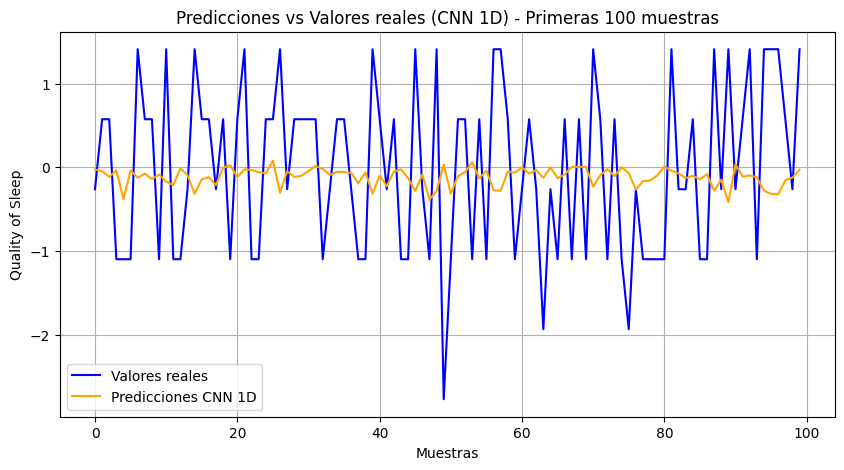

In [ ]:
plt.figure(figsize=(10,5))
plt.plot(range(100), y_true_cnn[:100], label="Valores reales", color="blue")
plt.plot(range(100), y_pred_cnn[:100], label="Predicciones CNN 1D", color="orange")
plt.title("Predicciones vs Valores reales (CNN 1D) - Primeras 100 muestras")
plt.xlabel("Muestras")
plt.ylabel("Quality of Sleep")
plt.legend()
plt.grid(True)
plt.show()


**Análisis del modelo CNN 1D**

**Comportamiento durante el entrenamiento**

La curva de pérdida mostró una tendencia general descendente, aunque con algunas fluctuaciones entre épocas. El valor final de loss fue bajo (0.47), lo que indica que el modelo logró aprender patrones útiles del conjunto de entrenamiento.

**Evaluación del grafico**

En el gráfico de las primeras 100 muestras, se observa que las predicciones siguen la forma general de los valores reales, pero con menor amplitud. El modelo tiende a subestimar los valores altos de Quality of Sleep, lo que sugiere que aún no captura completamente la variabilidad del fenómeno, la diferencia entre curvas indica que hay espacio para mejorar la precisión, especialmente en los extremos.

El modelo es rápido de entrenar y eficiente en secuencias temporales cortas,captura bien las tendencias generales del sueño, lo que lo hace útil para predicciones aproximadas pero es sensible a la escala de los datos, si no se desnormaliza correctamente, las predicciones pueden parecer erróneas. puede tener dificultades para representar variaciones abruptas o valores extremos.

**Conclusión**

El modelo CNN 1D logra una aproximación razonable a la calidad del sueño, siguiendo la forma general de los datos reales. Aunque presenta cierta subestimación en los valores altos, su rendimiento es sólido para tareas de predicción básica. Con ajustes en hiperparámetros, secuenciación y normalización, puede mejorar aún más.

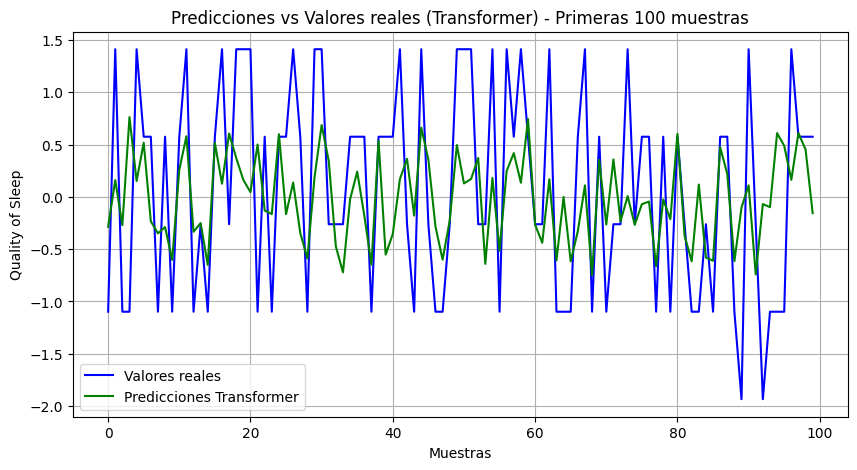

In [ ]:
plt.figure(figsize=(10,5))
plt.plot(range(100), y_true_trans[:100], label="Valores reales", color="blue")
plt.plot(range(100), y_pred_trans[:100], label="Predicciones Transformer", color="green")
plt.title("Predicciones vs Valores reales (Transformer) - Primeras 100 muestras")
plt.xlabel("Muestras")
plt.ylabel("Quality of Sleep")
plt.legend()
plt.grid(True)
plt.show()


**Análisis del modelo Transformer**

**Comportamiento durante el entrenamiento**

El loss inicial fue alto (5.86), pero descendió rápidamente en las primeras épocas.A partir de la época 5, el modelo mostró una curva de pérdida estable y consistente, terminando cerca de 0.52, lo que indica buena convergencia.

**Evaluación del grafico**

En el gráfico de las primeras 100 muestras, las predicciones del Transformer siguen la forma general de los valores reales, aunque con menor amplitud, al igual que el CNN, tiende a subestimar los valores altos, pero lo hace de forma más suave y menos errática. La curva verde de predicción es más suave y estable, lo que sugiere que el modelo está capturando dependencias largas sin sobreajustarse. Esto refuerza la idea de que el Transformer generaliza mejor en secuencias largas, aunque puede suavizar demasiado las variaciones.


Este modelo demostro ser excelente para capturar dependencias temporales complejas, curva de entrenamiento es más estable que el CN, ademas, las predicciones son más suaves y consistentes, lo que puede ser útil para aplicaciones donde se prioriza la estabilidad. Pero puede suavizar en exceso los valores, perdiendo precisión en los extremos, esto puede requierir más recursos computacionales y tiempo de entrenamiento que el CNN.

**Conclusión**

El modelo Transformer logra una predicción más estable y coherente de la calidad del sueño, con una curva de entrenamiento bien comportada y resultados visuales que siguen la tendencia general de los datos reales. Aunque tiende a suavizar los valores extremos, su capacidad para modelar secuencias largas lo convierte en una opción robusta para tareas de predicción temporal.